In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from astropy.coordinates import SkyCoord
from astropy import units
from astropy.io import fits 
from astropy.wcs import WCS
from pygdsm import GlobalSkyModel
import healpy as hp

In [ ]:
parent_dir = '/srv/nmohamme/notebooks/FRII_tidy/QU-Fitting_depol/QU_results/'

In [8]:
clist = SkyCoord([130,136,140,134, 143.2,132, 150]*units.deg, [5.0,0,5,3.5, 7.6, 12, 20]*units.deg, frame='galactic')
sampler_used = 'pymultinest' #reccomended sampling model
model_used = 33 
drag_beam_eff= 0.7 #Beam efficiency for Dragons
note = f'may2' #Any notes you want to add to the directory name


c=clist[5]
data = {}
directory = str(int(c.l.value)) + '_' + str(int(c.b.value))+'_m'+str(model_used)+'_'+str(sampler_used)+'_'+str(drag_beam_eff)+'_'+str(note)
path = parent_dir+directory
fn = path+'/qufit_' + str(int(c.l.value)) + '_' + str(int(c.b.value))+'_m'+str(model_used)+'_'+str(sampler_used)+'.json'
with open(fn, 'r') as json_file:
    key = f"{int(c.l.value)},{int(c.b.value)}"
    data = json.load(json_file)

q = np.load(parent_dir+'/spectra_files/'+directory + 'qArr_' + str(int(c.l.value)) + '_' + str(int(c.b.value))+'.npy')
u = np.load(parent_dir+'/spectra_files/'+directory + 'uArr_' + str(int(c.l.value)) + '_' + str(int(c.b.value))+'.npy')
data_freq = np.load(parent_dir+'/spectra_files/'+directory +'freqArr_' + str(int(c.l.value)) + '_' + str(int(c.b.value))+'.npy')

In [9]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_clean_tot.fits'
chime_FDF = fits.getdata(fn)
hdr_chime_FDF = fits.getheader(fn)
wcs_chime = WCS(hdr_chime_FDF)
FD_Arr_chime = wcs_chime.wcs_pix2world(1, 1, np.arange(hdr_chime_FDF['NAXIS3']), 1)[2]

def get_chime_los(c):
    l = c.l.value
    b = c.b.value
    lpix = int(wcs_chime.celestial.wcs_world2pix(l, b, 1)[0])
    bpix = int(wcs_chime.celestial.wcs_world2pix(l, b, 1)[1])
    
    
    return chime_FDF[:, bpix, lpix]
#---------------------------------------------------------------------------------------------------

fn = '/srv/data/gmims/gmims-hbn/GMIMS-HBN_v1_gal_car_FD_PI.fits'
gmims_FDF = fits.getdata(fn)
hdr_gmims_FDF = fits.getheader(fn)
wcs_gmims = WCS(hdr_gmims_FDF)
FD_Arr_gmims = wcs_gmims.wcs_pix2world(1, 1, np.arange(hdr_gmims_FDF['NAXIS3']), 1)[2]


def get_gmims_los(c):
    l = c.l.value
    b = c.b.value
    lpix = int(wcs_gmims.celestial.wcs_world2pix(l, b, 1)[0])
    bpix = int(wcs_gmims.celestial.wcs_world2pix(l, b, 1)[1])
    
    
    return gmims_FDF[:, bpix, lpix]

#---------------------------------------------------------------------------------------------------

fn = '/srv/data/dragons/FD_cube_DRAGONS_v2.fits'
drags_FDF = fits.getdata(fn)
hdr_drags_FDF = fits.getheader(fn)
wcs_drags = WCS(hdr_drags_FDF)
FD_Arr_drags = wcs_drags.wcs_pix2world(1, 1, np.arange(hdr_drags_FDF['NAXIS3']), 1)[2]


def get_drags_los(c):
    l = c.l.value
    b = c.b.value
    lpix = int(wcs_drags.celestial.wcs_world2pix(l, b, 1)[0])
    bpix = int(wcs_drags.celestial.wcs_world2pix(l, b, 1)[1])

    return drags_FDF[:, bpix, lpix]

#---------------------------------------------------------------------------------------------------

fn = '/home/nmohamme/FanRegionII/WMAP_data/wmap_band_iqumap_r9_9yr_K_v5.fits'
WMAP_data = fits.getdata(fn, exten_no=1)
#We use the GlobalSky Model for the Stokes I across both GMIMS and Dragons
gsm = GlobalSkyModel(freq_unit='MHz')
def get_WMAP_los(c):
    l = c.l.value
    b = c.b.value
    
    I = np.asarray(gsm.generate(22800)[hp.ang2pix(512, l,b, lonlat=True)])
    
    q = WMAP_data['Q_POLARISATION'][hp.ang2pix(512, l,b, lonlat=True)]/1000/I
    u = WMAP_data['U_POLARISATION'][hp.ang2pix(512, l,b, lonlat=True)]/1000/I
    p = np.sqrt(q**2+u**2)
    
    return{'p':p, 'q':q, 'u':u, 'I':I}

#---------------------------------------------------------------------------------------------------


k_B = 1.380649e-23
def do_dwingeloo(freq='1411', f=1411, LOS=[1, 1]):
    """ 
    Read the Dwingeloo data and returns dicionary of intensities at desired frequency & at the specific LOS
    
    Allowed Frequencies: 410, 465, 610, 820, 1411 #MHz
    
    """
    l = LOS[0]
    b = LOS[1]
    I = np.asarray(gsm.generate(f)[hp.ang2pix(512, l,b, lonlat=True)])

    l_list = []
    b_list = []
    ra_list = []
    dec_list = []
    PI_list = []
    gal_theta_list = []
    eq_theta_list = []
    
    fn = '/srv/data/dwingeloo_data/original/out' + freq

    with open(fn) as f:
        for line in f:
            line = f.readline()
            l_list.append(float(line[0:7]))
            b_list.append(float(line[7:13]))
            ra_list.append(float(line[13:19]))
            dec_list.append(float(line[19:25]))
            PI_list.append(float(line[25:31]))
            gal_theta_list.append(float(line[31:37]))
            eq_theta_list.append(float(line[37:43]))

    f.close()

    l_arr = np.asarray(l_list)*units.deg
    b_arr = np.asarray(b_list)*units.deg
    b_arr[b_arr > 180*units.deg] -= 360*units.deg

    j = int(np.argmin(np.abs(np.asarray(l_list)-LOS[0])+np.abs(np.asarray(b_list)-LOS[1]))) #Index of the closest pixel to the LOS
    
    dwinge_q = np.asarray(PI_list)*np.cos(2*np.asarray(gal_theta_list)*np.pi/180.)/I
    dwinge_u = np.asarray(PI_list)*np.sin(2*np.asarray(gal_theta_list)*np.pi/180.)/I
    
    return {'pI':PI_list[j], 'q':dwinge_q[j], 'u':dwinge_u[j], 'I':I}

dwi_keys = ['408', '465', '610', '820', '1411'] #used to index the returned dictionary of do_dwingeloo
dwi_freq = np.asarray([0.408,0.465,0.610,0.820,1.411])*units.GHz #Frequencies for plotting scatter of dwingeloo data

dwing_q = []
dwing_u = []
for key, f in zip(dwi_keys, dwi_freq):
    dwing_q.append(do_dwingeloo(key, f.value*1000, [c.l.value, c.b.value])['q'])
    dwing_u.append(do_dwingeloo(key, f.value*1000, [c.l.value, c.b.value])['u'])

In [10]:
def model5(pDict, lamSqArr_m2):
    """Single Faraday component with Tribble depolarisation and anchored p0"""
    # Calculate the complex fractional q and u spectra
    ref_p = get_WMAP_los(c)['p']
    pArr = ref_p*np.ones_like(lamSqArr_m2)
    
    quArr = (
        pArr
        * np.exp(2j * (np.radians(pDict[0]) + pDict[1] * lamSqArr_m2))
        *(pDict[3]**(-0.5)/(pDict[2]*lamSqArr_m2*np.sqrt(2)))
    )

    return quArr



def model6(pDict, lamSqArr_m2):
    """Single Faraday component with Tribble depolarisation"""

    # Calculate the complex fractional q and u spectra
    pArr = pDict[0] * np.ones_like(lamSqArr_m2)
    quArr = (
        pArr
        * np.exp(2j * (np.radians(pDict[1]) + pDict[2] * lamSqArr_m2))
        *(pDict[4]**(-0.5)/(pDict[3]*lamSqArr_m2*np.sqrt(2)))
    )

    return quArr


def model33(pDict, lamSqArr_m2):
    """Two separate Faraday components, averaged within same telescope beam
    (i.e., unresolved), with a common Tribble depolarisation term."""

    # Calculate the complex fractional q and u spectra
    pArr1 = pDict[1] * np.ones_like(lamSqArr_m2)
    pArr2 = pDict[2] * np.ones_like(lamSqArr_m2)
    quArr1 = pArr1 * np.exp(
        2j * (np.radians(pDict[3]) + pDict[5] * lamSqArr_m2)
    )
    quArr2 = pArr2 * np.exp(
        2j * (np.radians(pDict[4]) + pDict[6] * lamSqArr_m2)
    )
    quArr = (quArr1 + quArr2) * np.exp(
        (pDict[0]**(-0.5)/(pDict[7]*lamSqArr_m2*np.sqrt(2)))
    )

    return quArr


def model55(pDict, lamSqArr_m2, ref_p=1, ref_freq=22.8e9):
    """Two separate Faraday components, with Tribble depolarization and anchored p0"""
    # Calculate the complex fractional q and u spectra
    ref_p = get_WMAP_los(c)['p']
    pArr1 = ref_p*np.ones_like(lamSqArr_m2)
    pArr2 = ref_p*np.ones_like(lamSqArr_m2)
    
    quArr1 = pArr1 * np.exp(
        2j * (np.radians(pDict[1]) + pDict[3] * lamSqArr_m2)
    )
    quArr2 = pArr2 * np.exp(
        2j * (np.radians(pDict[2]) + pDict[4] * lamSqArr_m2)
    )
    quArr = (quArr1 + quArr2) * np.exp(
        (pDict[0]**(-0.5)/(pDict[5]*lamSqArr_m2*np.sqrt(2)))
    )

    return quArr




In [11]:
model = locals()[f'model{model_used}']

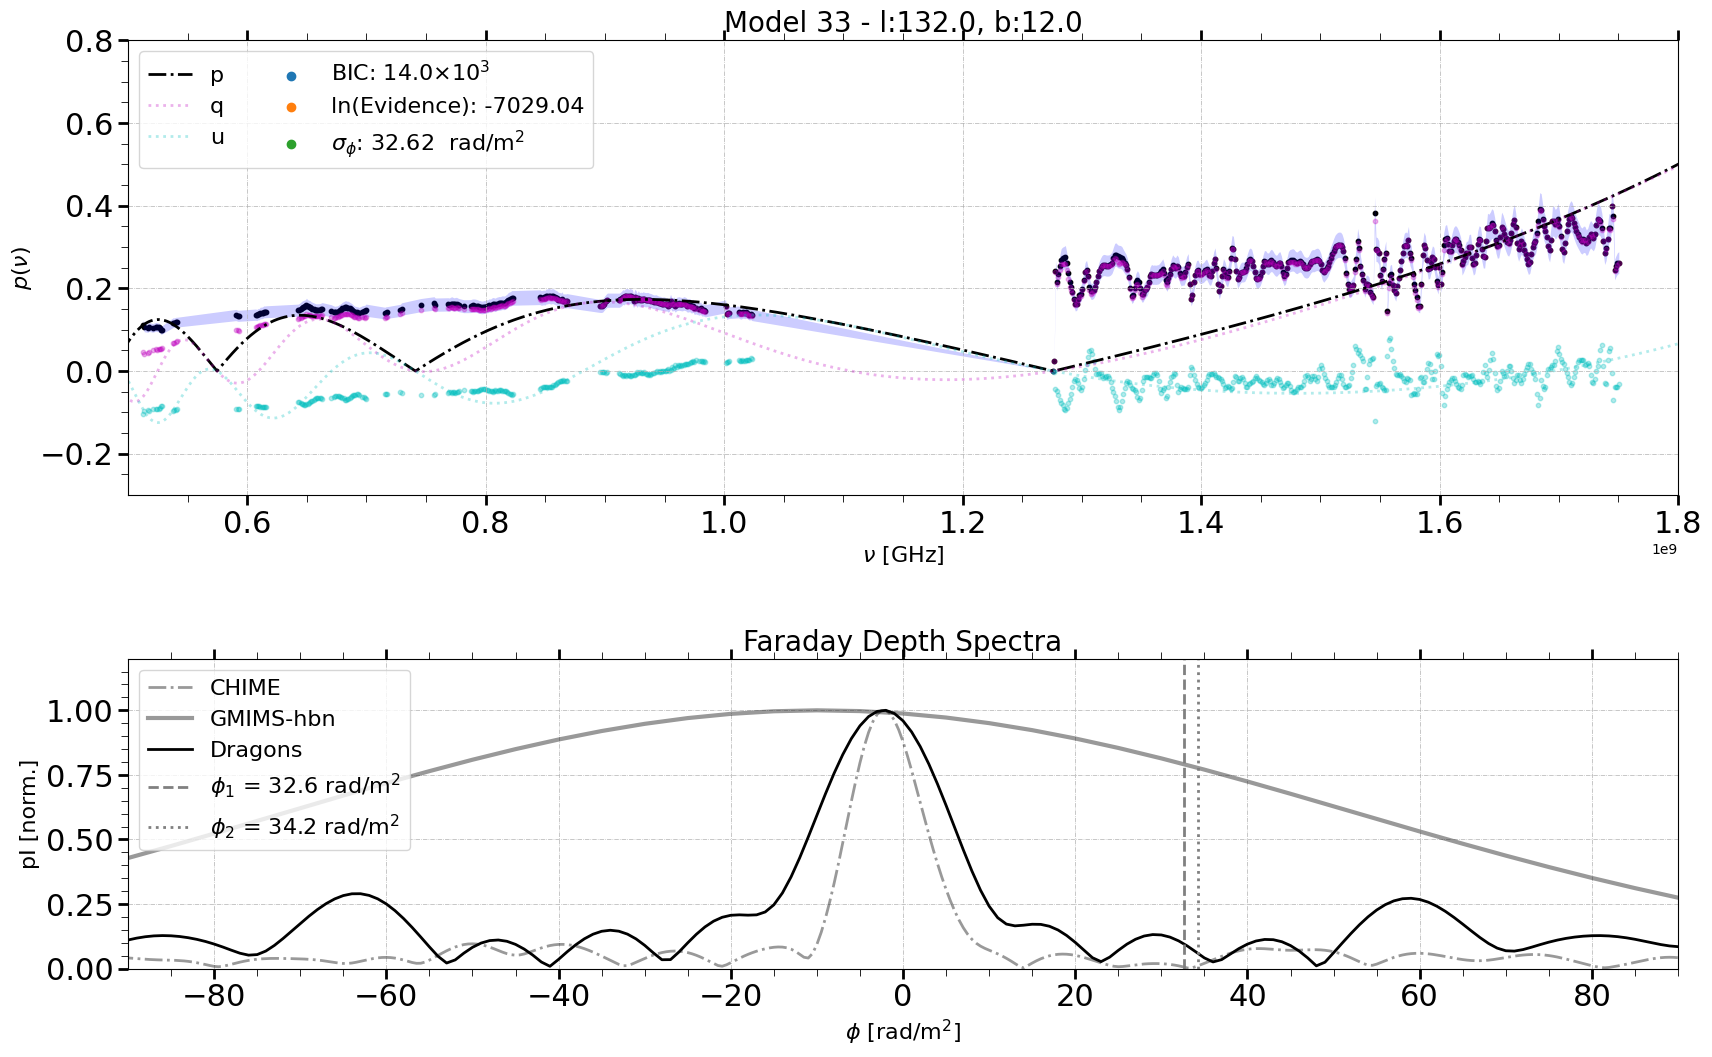

In [12]:
lamSqArr_m2 = np.linspace(0.001, 2, 10000)
nuArr_Hz= 3e8/np.sqrt(lamSqArr_m2)
fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(211)


ax.scatter(data_freq, np.sqrt(q**2+u**2), c='k', s=10)

y= np.sqrt(q**2+u**2)
ax.fill_between(data_freq, y+y*0.1, y-y*0.1, alpha=0.2, color='blue', antialiased=True, lw=0)

ax.plot(nuArr_Hz, np.abs(model(data['values'], lamSqArr_m2)), c='k', lw=2, ls='-.', label='p')
ax.scatter(data_freq, q, s=10, alpha=0.3, c='m')
ax.scatter(data_freq, u, s=10, alpha=0.3, c='c')
ax.plot(nuArr_Hz, np.real(model(data['values'], lamSqArr_m2)), c='m', lw=2, ls='dotted', label='q', alpha=0.3)
ax.plot(nuArr_Hz, np.imag(model(data['values'], lamSqArr_m2)), c='c', lw=2, ls='dotted', label='u', alpha=0.3)
#ax.scatter(dwi_freq.to(units.Hz).value, np.sqrt(np.asarray(dwing_q)**2+np.asarray(dwing_u)**2), s=100, alpha=1, c='r', label='Dwingeloo', marker='x')
ax.scatter([],[], label=f'BIC: {round(data["BIC"]/1000,1)}' + r'$\times 10^{3}$')
ax.scatter([],[], label=f'ln(Evidence): {round(data["ln(EVIDENCE) "],2)}')
sigma = data['values'][3]
ax.scatter([],[], label=r'$\sigma_{\phi}$: ' + f'{round(sigma,2)} ' + r' rad/m$^2$')



ax.set_ylim(-0.3, 0.8)
ax.set_xlim(0.5e9, 1.8e9)

ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
ax.set_title(f'Model {model_used} - l:{c.l.value}, b:{c.b.value}', fontsize=20)

ax.set_xlabel(r'$\nu$ [GHz]', fontsize=16)
ax.set_ylabel(r'${p}(\nu)$', fontsize=16);
ax.legend(loc='upper left', fontsize=16, ncol=2)

###############################################################

ax = fig.add_subplot(212)
ax.plot(FD_Arr_chime, get_chime_los(c)/np.nanmax(get_chime_los(c)), c='k', lw=2, alpha=0.4, label='CHIME', linestyle='-.')
ax.plot(FD_Arr_gmims, get_gmims_los(c)/np.nanmax(get_gmims_los(c)), c='k', lw=3, alpha=0.4, label='GMIMS-hbn')
ax.plot(FD_Arr_drags, get_drags_los(c)/np.nanmax(get_drags_los(c)), c='k', lw=2, alpha=1, label='Dragons')


ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
ax.set_title(f'Faraday Depth Spectra', fontsize=20)

#ax.axvline(data['values'][2], c='0.5', ls='--', lw=2, label = r'$\phi_{1}$ = '+f'{round(data["values"][2], 1)}' + r' rad/m$^2$') #use for model 5

#ax.axvline(data['values'][5], c='0.5', ls='--', lw=2, label = r'$\phi_{1}$ = '+f'{round(data["values"][5], 1)}' + r' rad/m$^2$') #use for model 6
#ax.axvline(data['values'][6], c='0.5', ls='dotted', lw=2, label = r'$\phi_{2}$ = '+f'{round(data["values"][6], 1)}' + r' rad/m$^2$')

ax.axvline(data['values'][3], c='0.5', ls='--', lw=2, label = r'$\phi_{1}$ = '+f'{round(data["values"][3], 1)}' + r' rad/m$^2$') #use for model 55
ax.axvline(data['values'][4], c='0.5', ls='dotted', lw=2, label = r'$\phi_{2}$ = '+f'{round(data["values"][4], 1)}' + r' rad/m$^2$')

ax.set_aspect(30)
ax.set_xlabel(r'$\phi$ [rad/m$^2$]', fontsize=16)
ax.set_ylabel(r'pI [norm.]', fontsize=16);
ax.set_xlim(-90, 90)
ax.set_ylim(0, 1.2)
ax.legend(loc='upper left', fontsize=16)

plt.savefig(f'/srv/nmohamme/notebooks/FRII_tidy/figures/fitted_spectra_{str(int(c.l.value))}_{str(int(c.b.value))}_m{model_used}_{note}_{str(sampler_used)}.png', bbox_inches='tight', pad_inches=0.1)

#blue haze is the error on the p

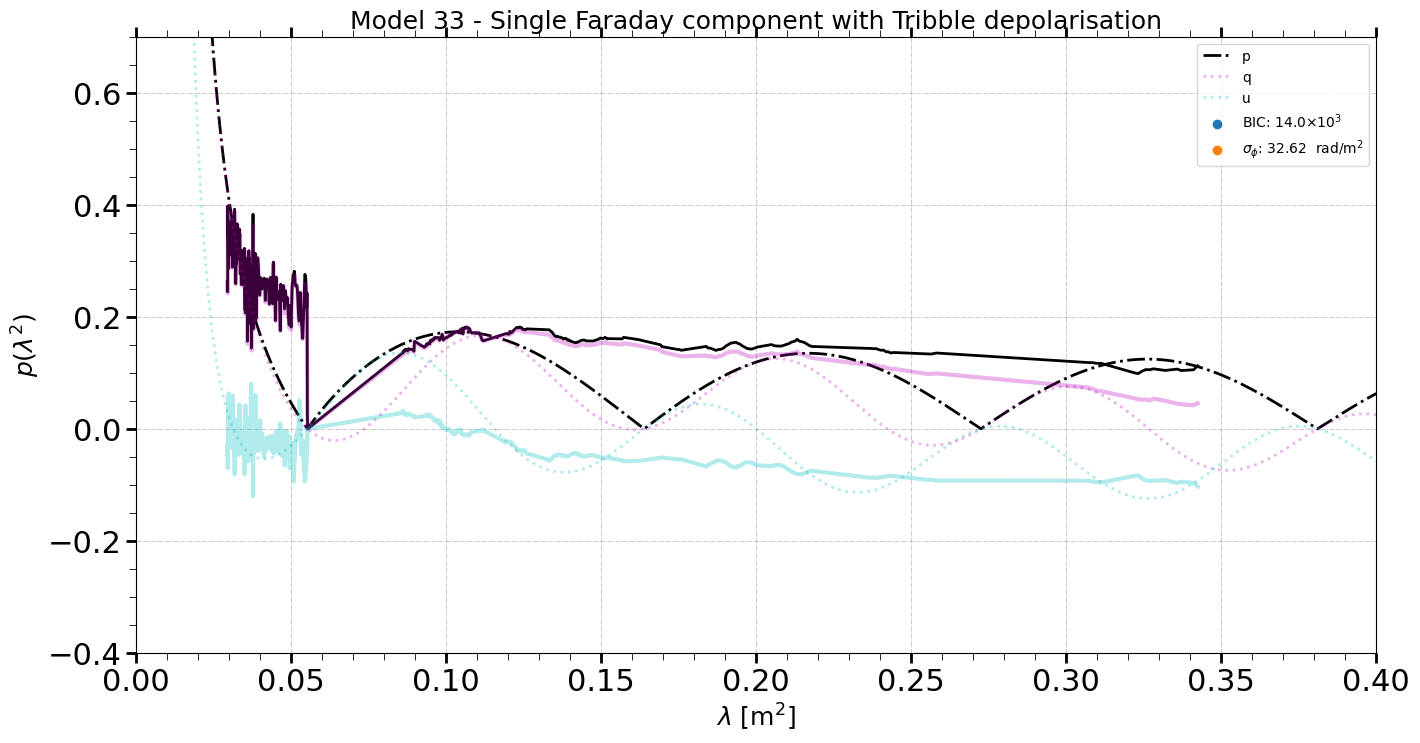

In [7]:
data_lamSq = (3e8/data_freq)**2
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)


ax.plot(data_lamSq, np.sqrt(q**2+u**2), c='k', lw=2)
ax.plot(lamSqArr_m2, np.abs(model(data['values'], lamSqArr_m2)), c='k', lw=2, ls='-.', label='p')
ax.plot(data_lamSq, q, lw=3, alpha=0.3, c='m')
ax.plot(data_lamSq, u, lw=3, alpha=0.3, c='c')
ax.plot(lamSqArr_m2, np.real(model(data['values'], lamSqArr_m2)), c='m', lw=2, ls='dotted', label='q', alpha=0.3)
ax.plot(lamSqArr_m2, np.imag(model(data['values'], lamSqArr_m2)), c='c', lw=2, ls='dotted', label='u', alpha=0.3)
ax.scatter([],[], label=f'BIC: {round(data["BIC"]/1000,1)}' + r'$\times 10^{3}$')
sigma = data['values'][3]
ax.scatter([],[], label=r'$\sigma_{\phi}$: ' + f'{round(sigma,2)} ' + r' rad/m$^2$')


ax.set_ylim(-0.4, 0.7)
ax.set_xlim(0, 0.4)

ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
ax.set_title(f'Model {model_used} - Single Faraday component with Tribble depolarisation', fontsize=18)

ax.set_xlabel(r'$\lambda$ [m$^2$]', fontsize=18)
ax.set_ylabel(r'${p}(\lambda^2)$', fontsize=18);
ax.legend()